In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
df= pd.read_csv('/content/RTA Dataset.csv')
print("Initial Dataset Info:")
print(df.info())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_alli

**DATA CLEANING** **AND PREPOCESSING**


1. Handle Missing Values

In [ ]:
df.isnull().sum()

,0
Time,0
Day_of_week,0
Age_band_of_driver,0
Sex_of_driver,0
Educational_level,741
Vehicle_driver_relation,579
Driving_experience,829
Type_of_vehicle,950
Owner_of_vehicle,482
Service_year_of_vehicle,3928


In [ ]:
categorical_cols = ['Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
                    'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
                    'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
                    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
                    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
                    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
                    'Vehicle_movement', 'Casualty_class', 'Sex_of_casualty',
                    'Age_band_of_casualty', 'Casualty_severity', 'Work_of_casuality',
                    'Fitness_of_casuality', 'Pedestrian_movement', 'Cause_of_accident']
for col in categorical_cols:
    df[col].fillna('Unknown')


In [ ]:
df['Number_of_vehicles_involved'].fillna(df['Number_of_vehicles_involved'].median())
df['Number_of_casualties'].fillna(df['Number_of_casualties'].median())

,Number_of_casualties
0,2
1,2
2,2
3,2
4,2
...,...
12311,1
12312,1
12313,1
12314,1


2. Convert Time to Datetime and Extract Hour

In [ ]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
df['Hour'] = df['Time'].dt.hour.fillna(df['Time'].dt.hour.median())


3. Standardize Categorical Data

In [ ]:
df['Type_of_vehicle'] = df['Type_of_vehicle'].replace({'Lorry (41?100Q)': 'Lorry (41-100Q)',
                                                       'Lorry (11?40Q)': 'Lorry (11-40Q)',
                                                       'Public (13?45 seats)': 'Public (13-45 seats)'})

In [ ]:
severity_order = ['Slight Injury', 'Serious Injury', 'Fatal injury']
df['Accident_severity'] = pd.Categorical(df['Accident_severity'], categories=severity_order, ordered=True)

In [ ]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day_of_week'] = pd.Categorical(df['Day_of_week'], categories=day_order, ordered=True)

4. Handle Outliers or Incorrect Data

In [ ]:
df['Casualty_severity'] = pd.to_numeric(df['Casualty_severity'], errors='coerce').fillna(3)

5. Drop Duplicates

In [ ]:
df.drop_duplicates(inplace=True)

6. Remove Unnecessary Whitespace and Correct Capitalization

In [ ]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip().str.title()

7. heck for Remaining Missing Values

In [ ]:
print("\nMissing Values After Cleaning:\n", df.isnull().sum())


Missing Values After Cleaning:
 Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                 4443
Sex_of_casualty                4443
Age_band_of_casualty           4443
Casualty_severity              

**Preprocessing for machine learning**

In [ ]:
df.replace('na', np.nan, inplace=True)


for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)


label_encoders = {}
X = df.drop(['Accident_severity', 'Number_of_vehicles_involved', 'Number_of_casualties'], axis=1)
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    else:
        X[col] = X[col].astype(float)


y_severity = df['Accident_severity']
y_vehicles = df['Number_of_vehicles_involved']
y_casualties = df['Number_of_casualties']


if y_severity.dtype == 'object':
    le_severity = LabelEncoder()
    y_severity = le_severity.fit_transform(y_severity)
    label_encoders['Accident_severity'] = le_severity
else:

    le_severity = LabelEncoder()
    y_severity = le_severity.fit_transform(y_severity)


le_vehicles = LabelEncoder()
y_vehicles = le_vehicles.fit_transform(y_vehicles)

le_casualties = LabelEncoder()
y_casualties = le_casualties.fit_transform(y_casualties)


X_train, X_test, y_severity_train, y_severity_test = train_test_split(X, y_severity, test_size=0.2, random_state=42)
_, _, y_vehicles_train, y_vehicles_test = train_test_split(X, y_vehicles, test_size=0.2, random_state=42)
_, _, y_casualties_train, y_casualties_test = train_test_split(X, y_casualties, test_size=0.2, random_state=42)


<ipython-input-134-0bf20fc4cb15>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
<ipython-input-134-0bf20fc4cb15>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

9. Save Cleaned Dataset

In [ ]:
df.to_csv('accidents_cleaned.csv', index=False)
print("\nCleaned Dataset Info:")
print(df.info())
print("\nSample of Cleaned Data:\n", df.head())


Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Time                         12316 non-null  datetime64[ns]
 1   Day_of_week                  12316 non-null  category      
 2   Age_band_of_driver           12316 non-null  int64         
 3   Sex_of_driver                12316 non-null  int64         
 4   Educational_level            12316 non-null  int64         
 5   Vehicle_driver_relation      12316 non-null  int64         
 6   Driving_experience           12316 non-null  int64         
 7   Type_of_vehicle              12316 non-null  int64         
 8   Owner_of_vehicle             12316 non-null  int64         
 9   Service_year_of_vehicle      12316 non-null  int64         
 10  Defect_of_vehicle            12316 non-null  int64         
 11  Area_accident_occu

**EXPLORATORY DATA ANALYSIS (EDA) AND SUMMARY STATISTICS**

1. Summary Statistics

In [ ]:
print("Summary Statistics:")
print(df.describe(include='all'))

Summary Statistics:
                                 Time Day_of_week  Age_band_of_driver  \
count                           12316       12316        12316.000000   
unique                            NaN           7                 NaN   
top                               NaN      Friday                 NaN   
freq                              NaN        2041                 NaN   
mean    1900-01-01 14:17:50.768106496         NaN            1.292952   
min               1900-01-01 00:01:00         NaN            0.000000   
25%               1900-01-01 10:31:00         NaN            0.000000   
50%               1900-01-01 15:10:00         NaN            1.000000   
75%               1900-01-01 18:10:00         NaN            2.000000   
max               1900-01-01 23:59:00         NaN            4.000000   
std                               NaN         NaN            1.337520   

        Sex_of_driver  Educational_level  Vehicle_driver_relation  \
count    12316.000000       12316.

2. Accident Severity Distribution

<ipython-input-151-154b63cfaa8f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Accident_severity', data=df, order=['Slight Injury', 'Serious Injury', 'Fatal injury'],palette='viridis')


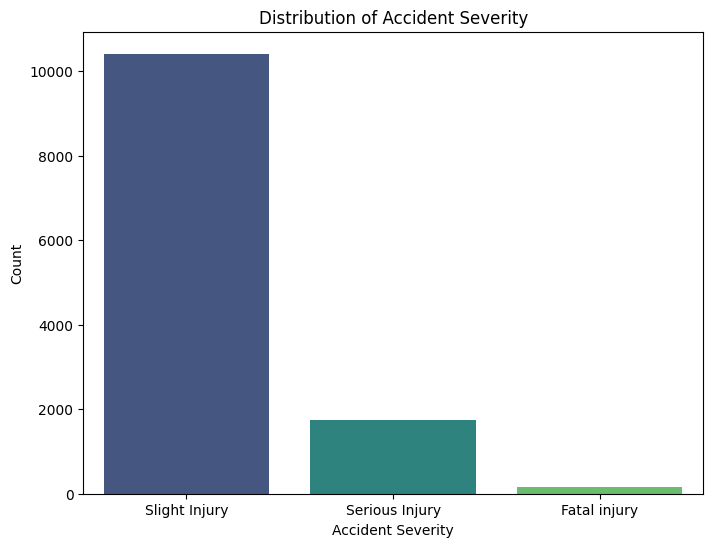

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Accident_severity', data=df, order=['Slight Injury', 'Serious Injury', 'Fatal injury'],palette='viridis')
plt.title('Distribution of Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.show()


3. Accidents by Day of Week

<ipython-input-149-704b7f4e00e8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Day_of_week', data=df,palette='Set1', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


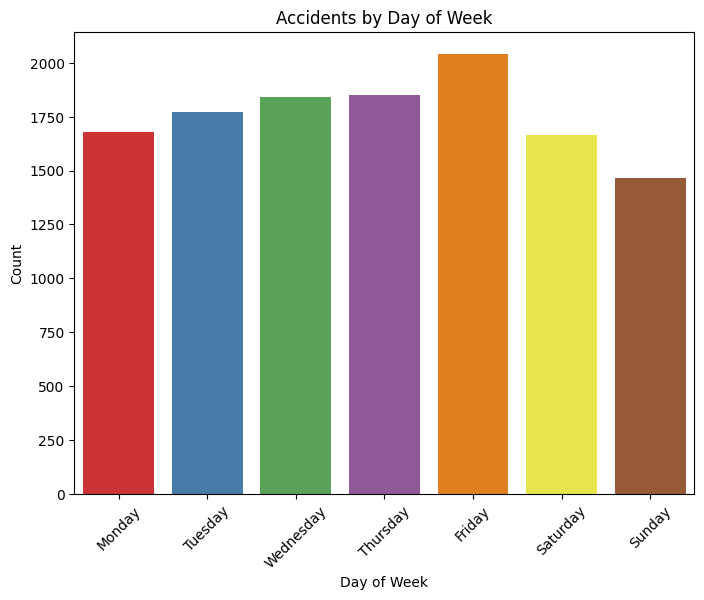

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Day_of_week', data=df,palette='Set1', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Accidents by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


4. Accidents by Hour of Day

<ipython-input-146-ab07d84d34b0>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['Hour'], bins=24, kde=True,palette='summer')


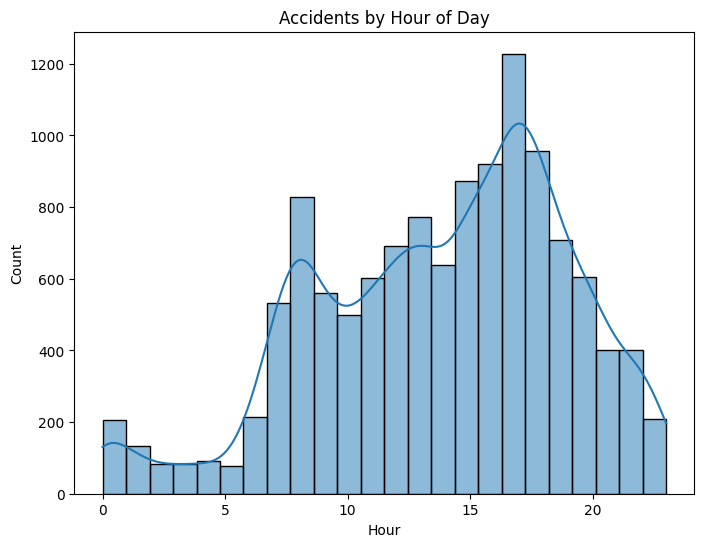

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Hour'], bins=24, kde=True,palette='summer')
plt.title('Accidents by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

5. Age Band of Driver vs. Accident Severity

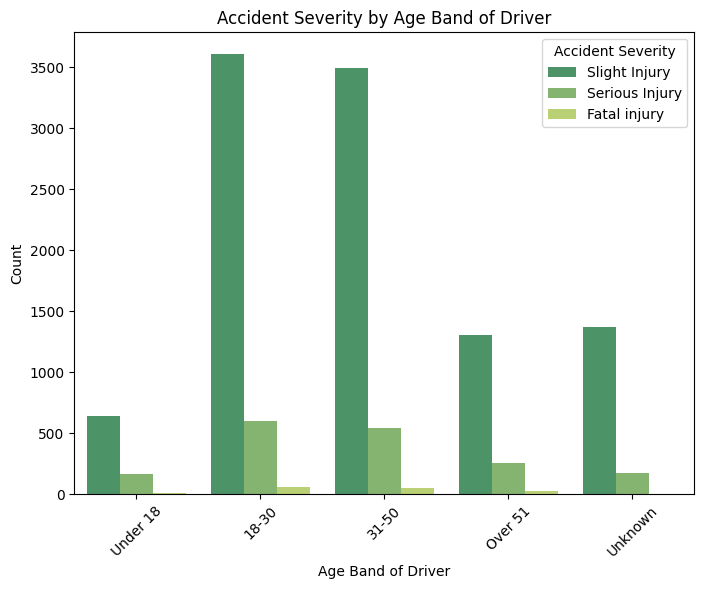

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Age_band_of_driver', hue='Accident_severity',palette='summer', data=df,
              order=['Under 18', '18-30', '31-50', 'Over 51', 'Unknown'])
plt.title('Accident Severity by Age Band of Driver')
plt.xlabel('Age Band of Driver')
plt.ylabel('Count')
plt.legend(title='Accident Severity')
plt.xticks(rotation=45)
plt.show()

6. Cause of Accident

<ipython-input-158-fa4b012f5e43>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_causes.index,palette='winter', y=top_causes.values)


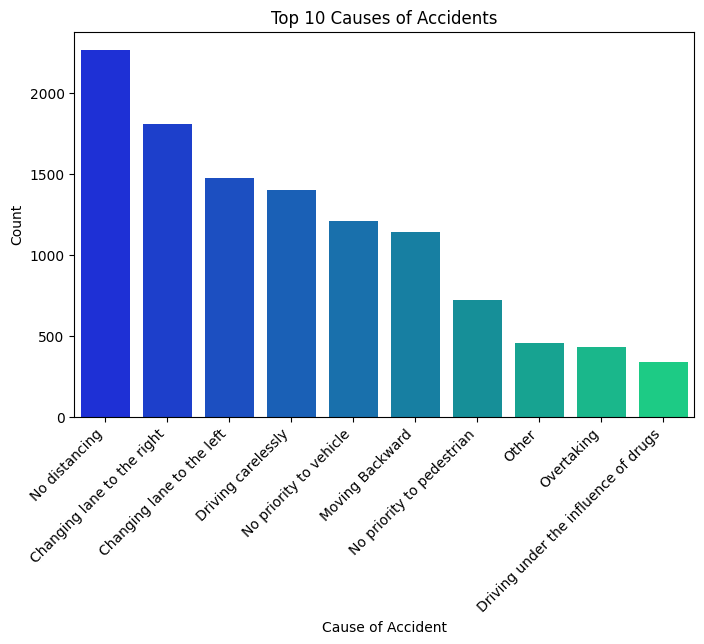

In [ ]:
plt.figure(figsize=(8, 5))
top_causes = df['Cause_of_accident'].value_counts().nlargest(10)
sns.barplot(x=top_causes.index,palette='winter', y=top_causes.values)
plt.title('Top 10 Causes of Accidents')
plt.xlabel('Cause of Accident')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


7. Road Surface Conditions vs. Accident Severity

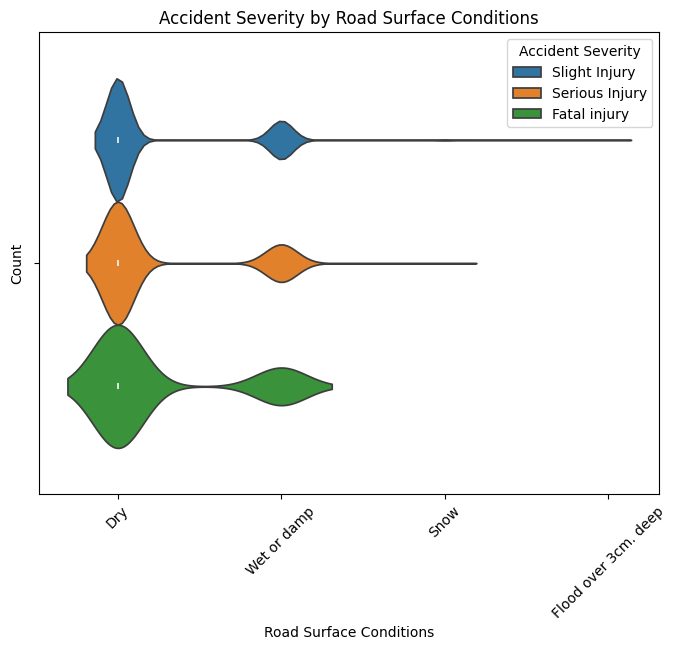

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='Road_surface_conditions', hue='Accident_severity', data=df)
plt.title('Accident Severity by Road Surface Conditions')
plt.xlabel('Road Surface Conditions')
plt.ylabel('Count')
plt.legend(title='Accident Severity')
plt.xticks(rotation=45)
plt.show()


8. Correlation Matrix

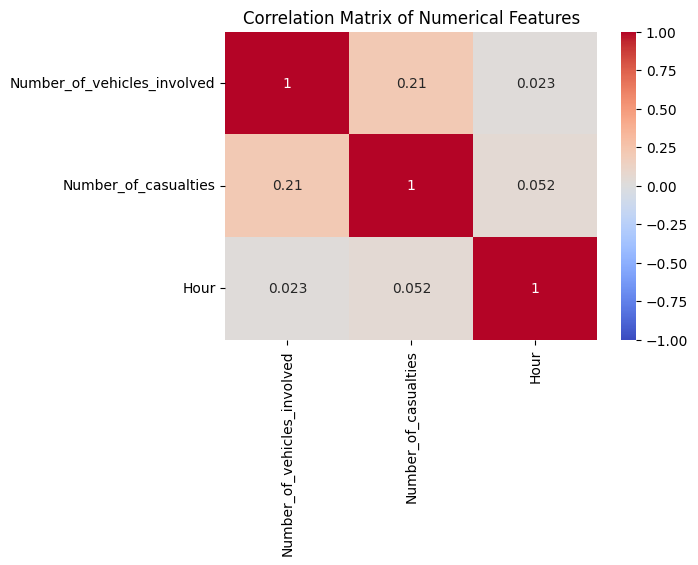

In [ ]:
numerical_cols = ['Number_of_vehicles_involved', 'Number_of_casualties', 'Hour']
plt.figure(figsize=(6, 4))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


9. Light Conditions vs. Accident Severity

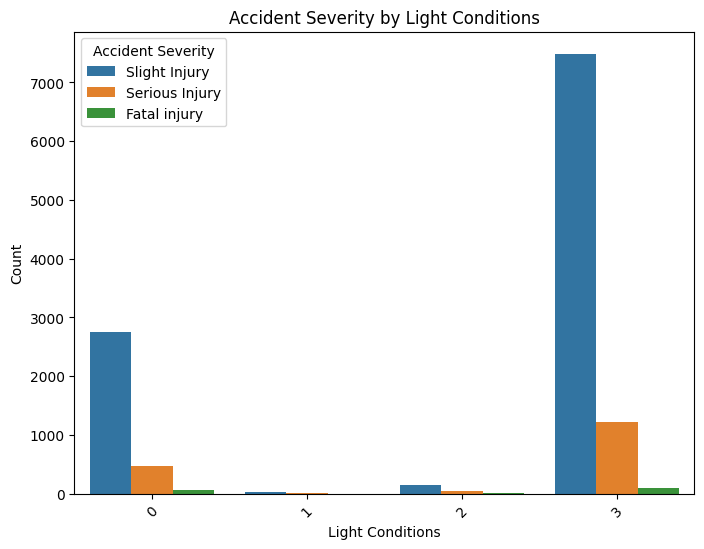

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Light_conditions', hue='Accident_severity', data=df)
plt.title('Accident Severity by Light Conditions')
plt.xlabel('Light Conditions')
plt.ylabel('Count')
plt.legend(title='Accident Severity')
plt.xticks(rotation=45)
plt.show()

10. Type of Collision

<ipython-input-115-e43a8bbcfc7b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_collisions.index, y=top_collisions.values, palette='winter')


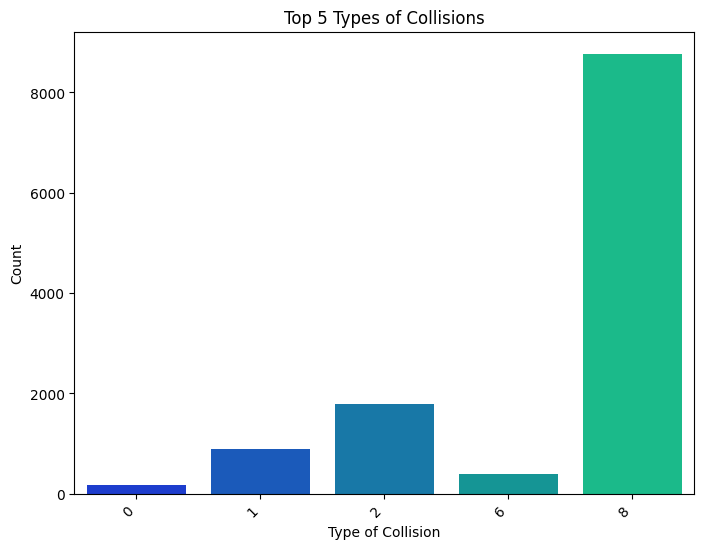

In [ ]:
plt.figure(figsize=(8, 6))
top_collisions = df['Type_of_collision'].value_counts().nlargest(5)
sns.barplot(x=top_collisions.index, y=top_collisions.values, palette='winter')
plt.title('Top 5 Types of Collisions')
plt.xlabel('Type of Collision')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
print("\nAdditional Insights:")
print(f"Total Accidents: {len(df)}")
print(f"Most Common Cause of Accident: {df['Cause_of_accident'].mode()[0]}")
print(f"Most Common Time of Day: {df['Hour'].mode()[0]}:00")
print(f"Most Frequent Day: {df['Day_of_week'].mode()[0]}")


Additional Insights:
Total Accidents: 12316
Most Common Cause of Accident: 10
Most Common Time of Day: 17:00
Most Frequent Day: Friday


11.  Outlier detection

<Axes: >

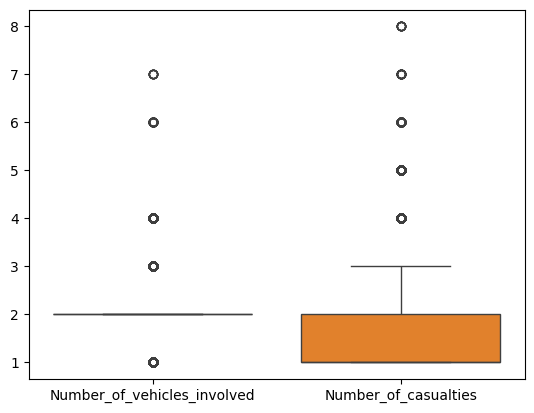

In [ ]:
sns.boxplot(data=df[['Number_of_vehicles_involved', 'Number_of_casualties']])


**MACHINE LEARNING MODELS**

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'SGD Classifier': SGDClassifier(loss='log_loss', random_state=42, max_iter=1000)
}


results = {}
for name, model in models.items():

    model.fit(X_train, y_severity_train)
    severity_pred = model.predict(X_test)
    severity_acc = accuracy_score(y_severity_test, severity_pred)


    model.fit(X_train, y_vehicles_train)
    vehicles_pred = model.predict(X_test)
    vehicles_acc = accuracy_score(y_vehicles_test, vehicles_pred)


    model.fit(X_train, y_casualties_train)
    casualties_pred = model.predict(X_test)
    casualties_acc = accuracy_score(y_casualties_test, casualties_pred)

    results[name] = [severity_acc, vehicles_acc, casualties_acc]
    print(f"{name} - Severity: {severity_acc:.4f}, Vehicles: {vehicles_acc:.4f}, Casualties: {casualties_acc:.4f}")


results_df = pd.DataFrame(results, index=['Accident Severity', 'Number of Vehicles', 'Number of Casualties']).T
print("\nResults Table:\n", results_df)



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

Logistic Regression - Severity: 0.8377, Vehicles: 0.6733, Casualties: 0.6713
Random Forest - Severity: 0.8377, Vehicles: 0.6737, Casualties: 0.6806


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Severity: 0.8429, Vehicles: 0.6782, Casualties: 0.6948
SGD Classifier - Severity: 0.8364, Vehicles: 0.1729, Casualties: 0.6623

Results Table:
                      Accident Severity  Number of Vehicles  \
Logistic Regression           0.837662            0.673295   
Random Forest                 0.837662            0.673701   
XGBoost                       0.842938            0.678166   
SGD Classifier                0.836445            0.172890   

                     Number of Casualties  
Logistic Regression              0.671266  
Random Forest                    0.680601  
XGBoost                          0.694805  
SGD Classifier                   0.662338  


**EDA USING VISUALIZATIONS**

ACCIDENT TRENDS AND PATTERNS

1. Trends by Time of Day

<ipython-input-85-199785c8ddfe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=df, palette='viridis')


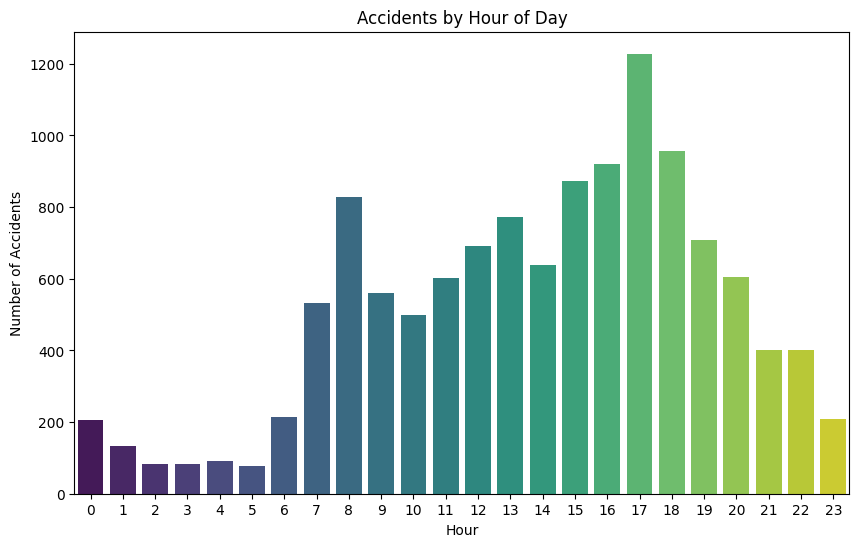

In [ ]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
df['Hour'] = df['Time'].dt.hour
plt.figure(figsize=(10, 6))
sns.countplot(x='Hour', data=df, palette='viridis')
plt.title('Accidents by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.show()

2. Trends by Weather Conditions

<ipython-input-86-1cbb06840288>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Weather_conditions', data=df, palette='coolwarm')


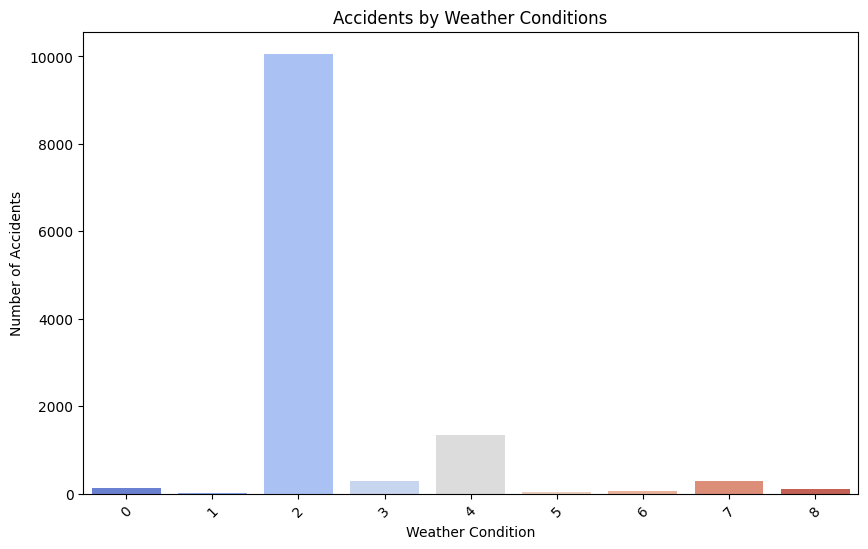

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Weather_conditions', data=df, palette='coolwarm')
plt.title('Accidents by Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()


3. Trends by Road Type & Surface

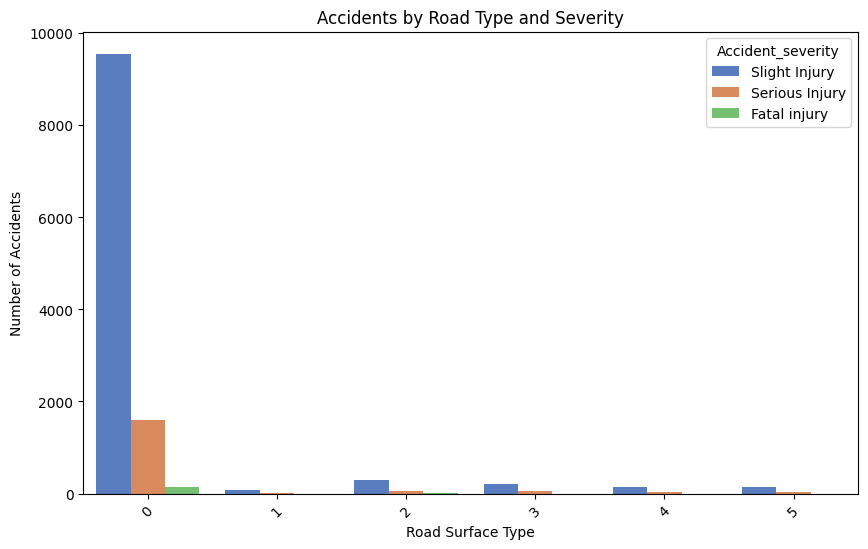

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Road_surface_type', hue='Accident_severity', data=df, palette='muted')
plt.title('Accidents by Road Type and Severity')
plt.xlabel('Road Surface Type')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

 4. Trends by Vehicle Type

<ipython-input-88-ce7aa78f07c6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Type_of_vehicle', data=df, palette='Set2', order=df['Type_of_vehicle'].value_counts().index)


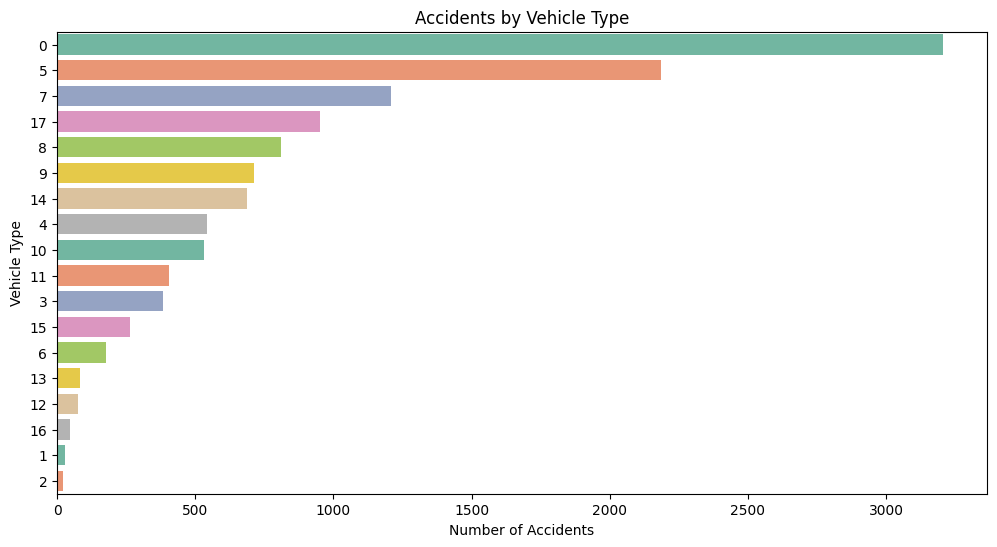

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Type_of_vehicle', data=df, palette='Set2', order=df['Type_of_vehicle'].value_counts().index)
plt.title('Accidents by Vehicle Type')
plt.xlabel('Number of Accidents')
plt.ylabel('Vehicle Type')
plt.show()

 5. Seasonal Trend (Using Day_of_week or Month)

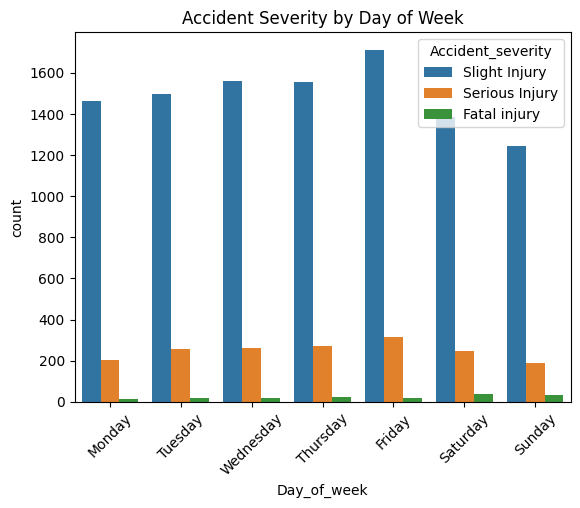

In [ ]:
sns.countplot(x='Day_of_week', hue='Accident_severity', data=df)
plt.title("Accident Severity by Day of Week")
plt.xticks(rotation=45)
plt.show()

**SEVERITY ANALYSIS**

1. Accident Severity vs Driver Age Band

<ipython-input-90-d60f110d04d3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Accident_severity', y='Age_band_of_driver', data=df, palette='pastel', order=['Slight Injury', 'Serious Injury', 'Fatal injury'])


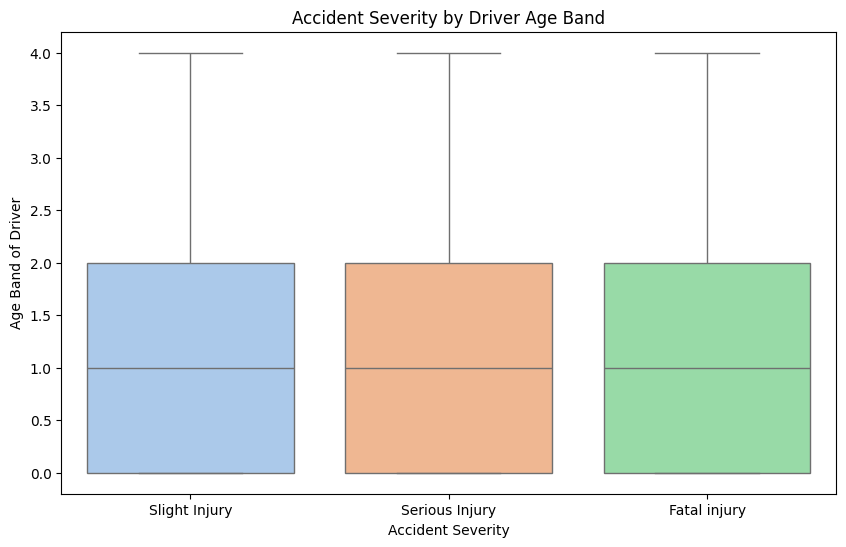

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Accident_severity', y='Age_band_of_driver', data=df, palette='pastel', order=['Slight Injury', 'Serious Injury', 'Fatal injury'])
plt.title('Accident Severity by Driver Age Band')
plt.xlabel('Accident Severity')
plt.ylabel('Age Band of Driver')
plt.show()

2. Severity vs Vehicle Condition

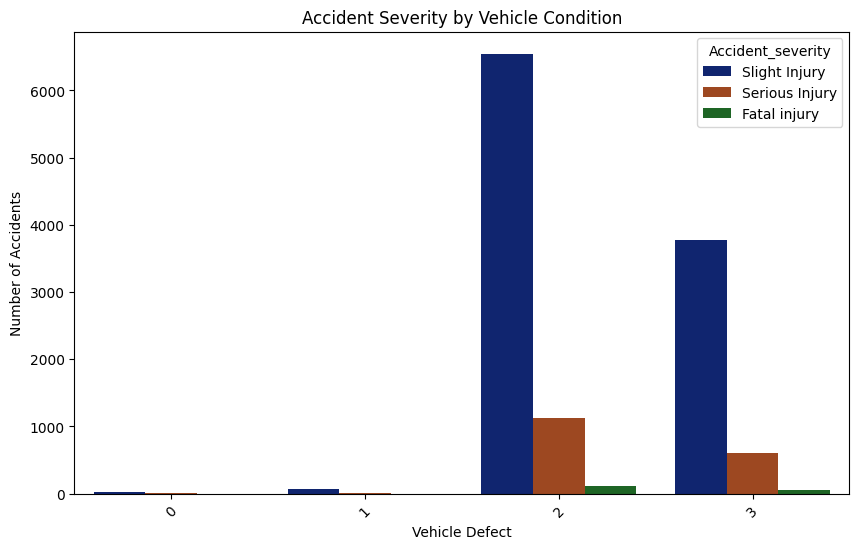

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Defect_of_vehicle', hue='Accident_severity', data=df, palette='dark')
plt.title('Accident Severity by Vehicle Condition')
plt.xlabel('Vehicle Defect')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

3. Severity vs Accident Location

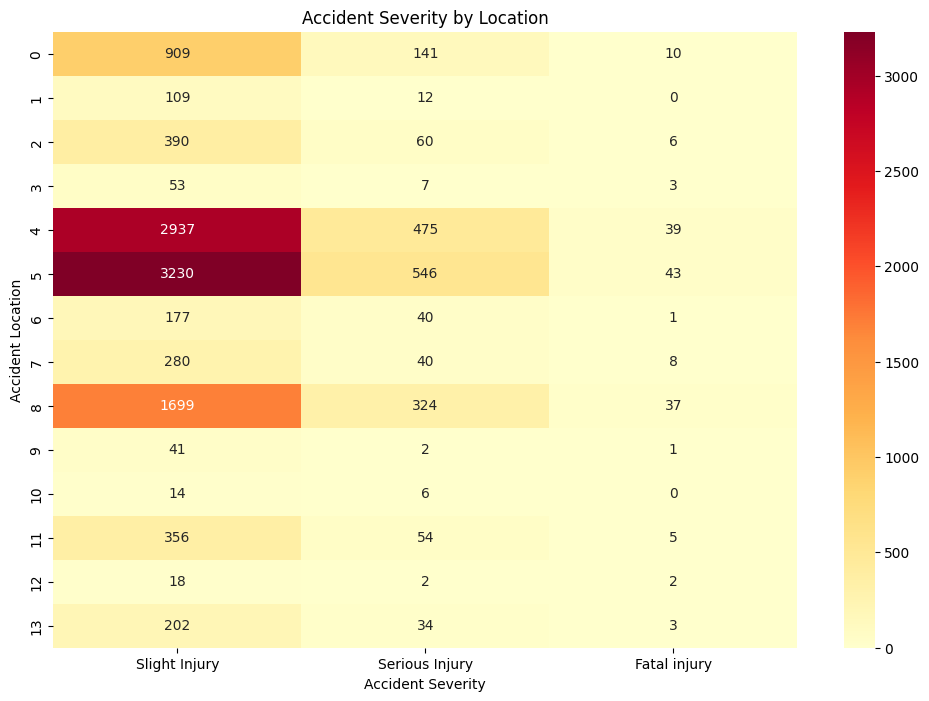

In [ ]:
severity_location = pd.crosstab(df['Area_accident_occured'], df['Accident_severity'])
plt.figure(figsize=(12, 8))
sns.heatmap(severity_location, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Accident Severity by Location')
plt.xlabel('Accident Severity')
plt.ylabel('Accident Location')
plt.show()


**GEOGRAPHICAL AND TEMPORAL INSIGHTS**

1. Accident Hotspot

<ipython-input-93-a1f17d16cf1c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Area_accident_occured', data=df, palette='Greens', order=df['Area_accident_occured'].value_counts().index)


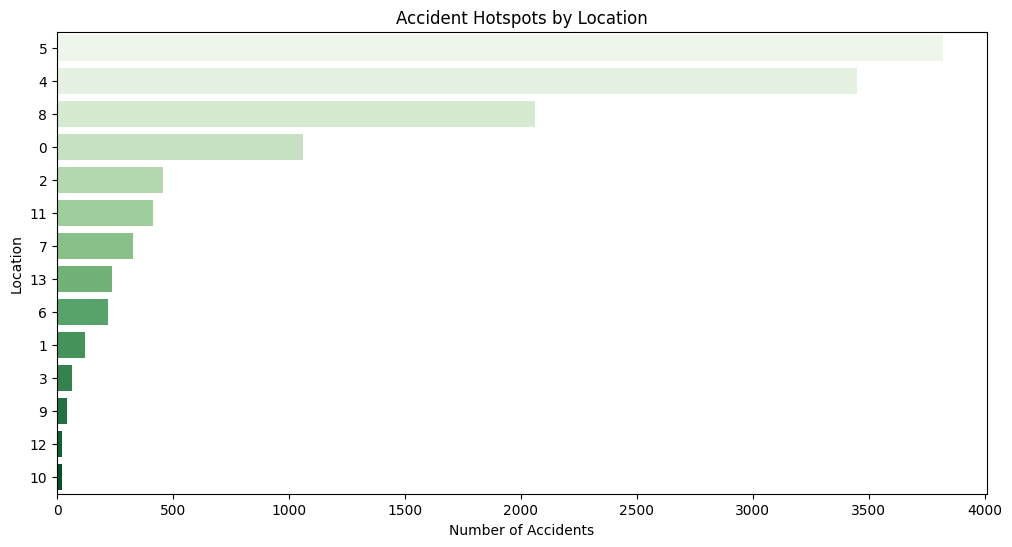

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Area_accident_occured', data=df, palette='Greens', order=df['Area_accident_occured'].value_counts().index)
plt.title('Accident Hotspots by Location')
plt.xlabel('Number of Accidents')
plt.ylabel('Location')
plt.show()

2.Day of Week

<ipython-input-94-11928fc937ba>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Day_of_week', data=df, palette='Set1', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


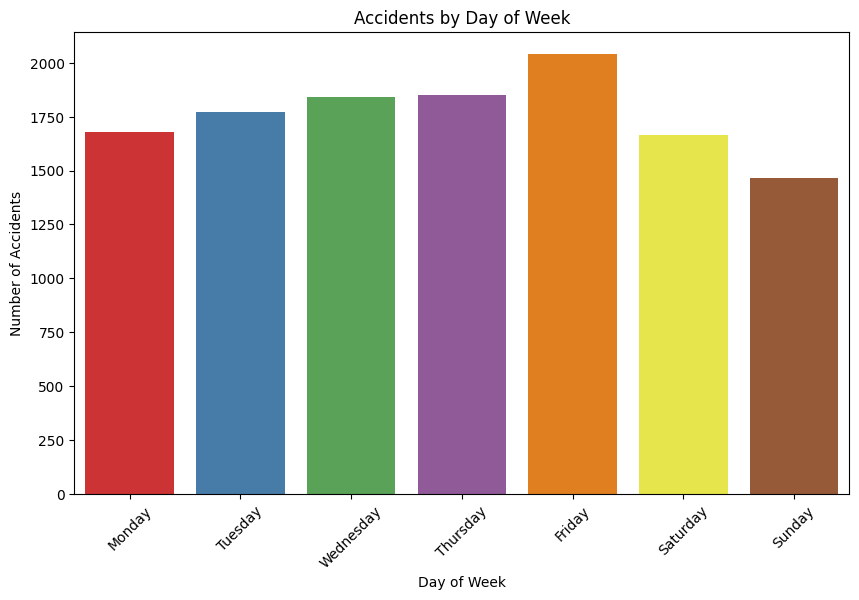

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Day_of_week', data=df, palette='Set1', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Accidents by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

**DEMOGRAPHIC ANALYSIS OF DRIVERS AND VICTIMS**

1. Age Band for Drivers

<ipython-input-95-5b1e737aca68>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Age_band_of_driver', data=df, palette='Blues')


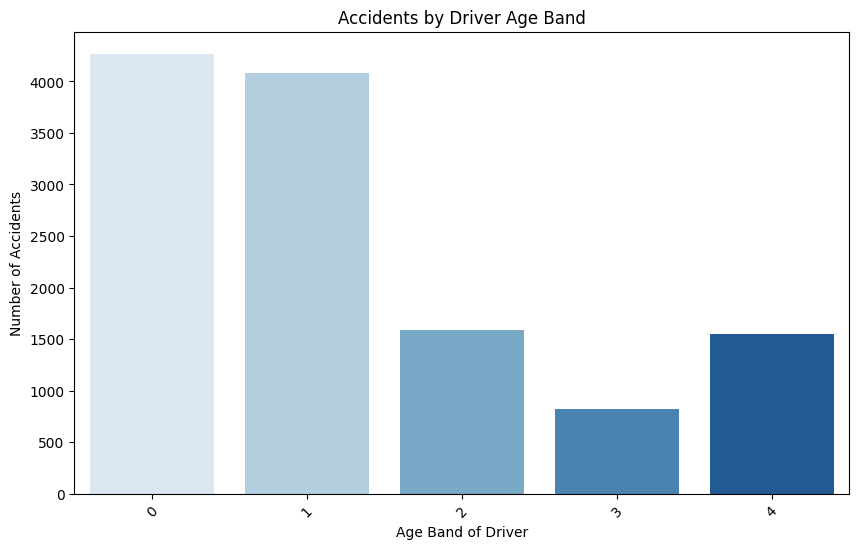

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Age_band_of_driver', data=df, palette='Blues')
plt.title('Accidents by Driver Age Band')
plt.xlabel('Age Band of Driver')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

2. Driver gendef Distribution in accidents

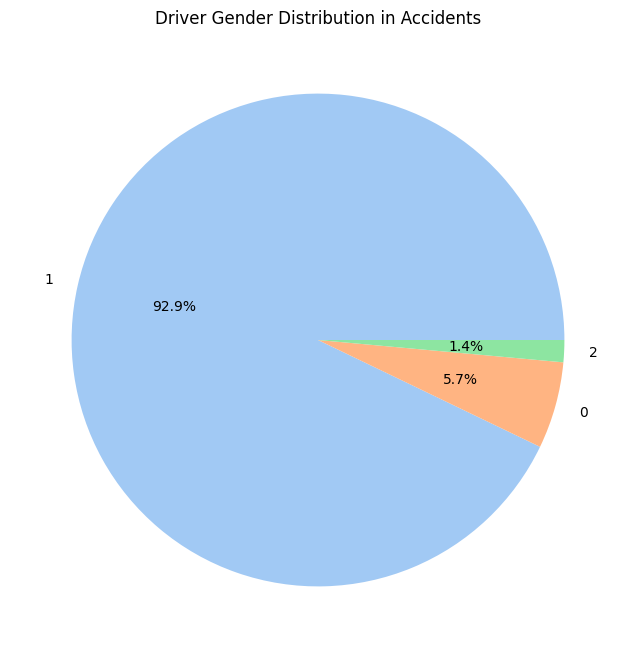

In [ ]:
gender_counts = df['Sex_of_driver'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Driver Gender Distribution in Accidents')
plt.show()

3.Experience vs. Severity Stacked

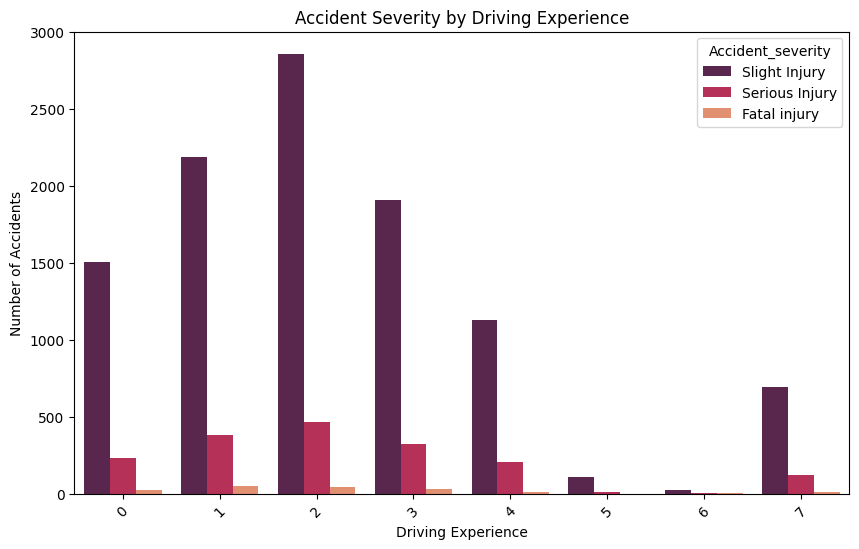

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Driving_experience', hue='Accident_severity', data=df, palette='rocket')
plt.title('Accident Severity by Driving Experience')
plt.xlabel('Driving Experience')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

**WEATHER AND ENVIROMENTAL IMAPCAT**

1.Weather vs. Severity Stacked

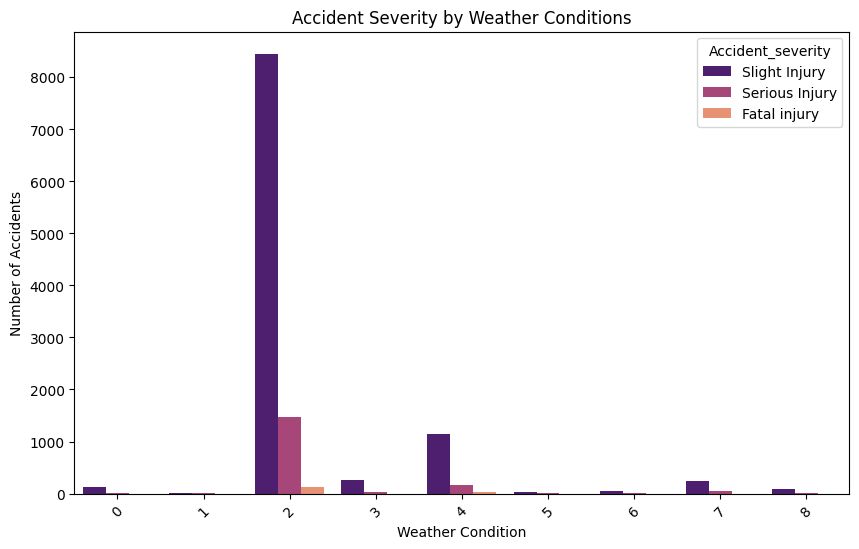

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Weather_conditions', hue='Accident_severity', data=df, palette='magma')
plt.title('Accident Severity by Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

2.Road Surface Conditions

<ipython-input-99-a3e907c9d209>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Road_surface_conditions', data=df, palette='winter')


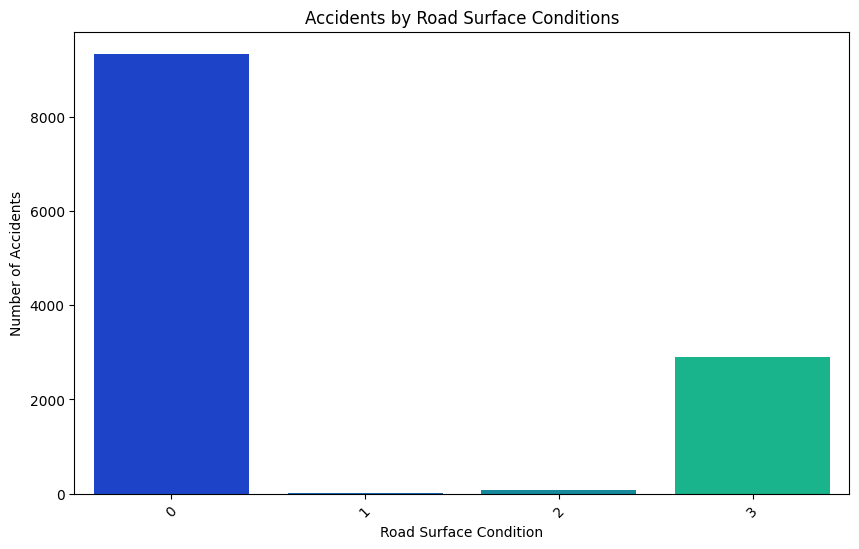

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Road_surface_conditions', data=df, palette='winter')
plt.title('Accidents by Road Surface Conditions')
plt.xlabel('Road Surface Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

3.Accidents by Area

<ipython-input-100-12703d003adc>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Area_accident_occured', order=df['Area_accident_occured'].value_counts().index,palette='cool')


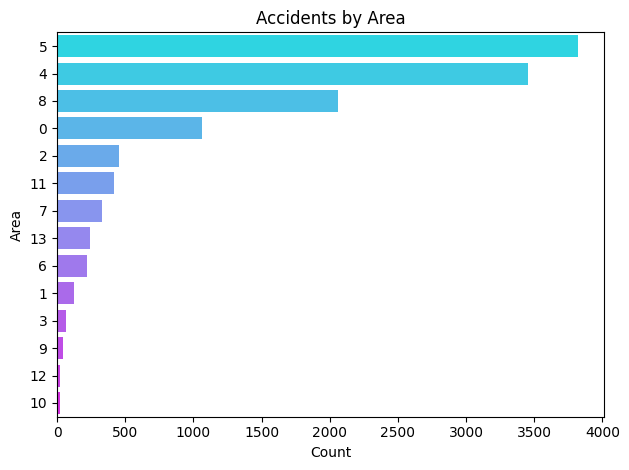

In [ ]:
sns.countplot(data=df, y='Area_accident_occured', order=df['Area_accident_occured'].value_counts().index,palette='cool')
plt.title('Accidents by Area')
plt.xlabel('Count')
plt.ylabel('Area')
plt.tight_layout()
plt.show()


**VEHICLE TYPE AND CONDITION ANALYSIS**

1. Vehicle Type vs. Severity

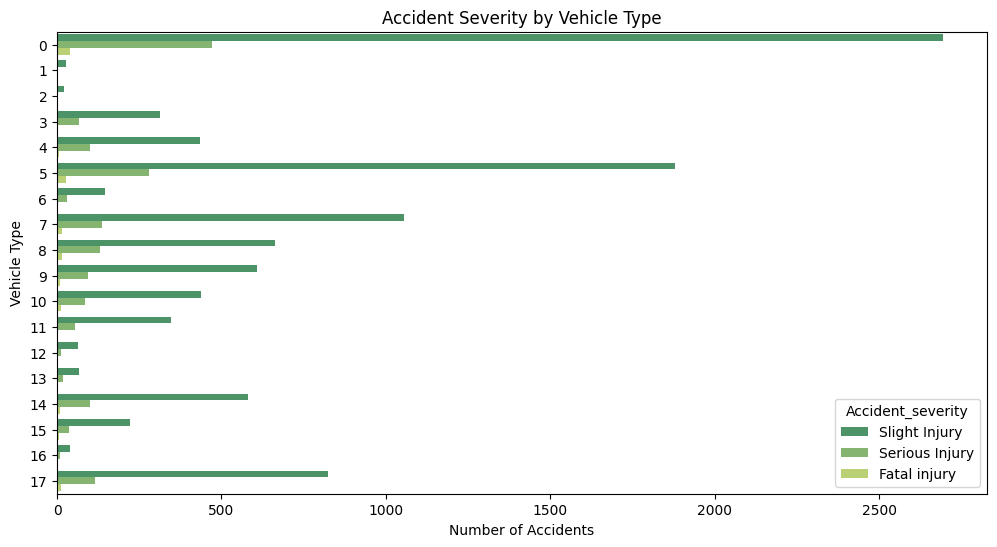

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Type_of_vehicle', hue='Accident_severity', data=df, palette='summer')
plt.title('Accident Severity by Vehicle Type')
plt.xlabel('Number of Accidents')
plt.ylabel('Vehicle Type')
plt.show()

2.Vehicle Age

<ipython-input-102-f32f7825c869>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Service_year_of_vehicle', data=df, palette='autumn', order=['Below 1yr', '1-2yr', '2-5yrs', '5-10yrs', 'Above 10yr', 'Unknown'])


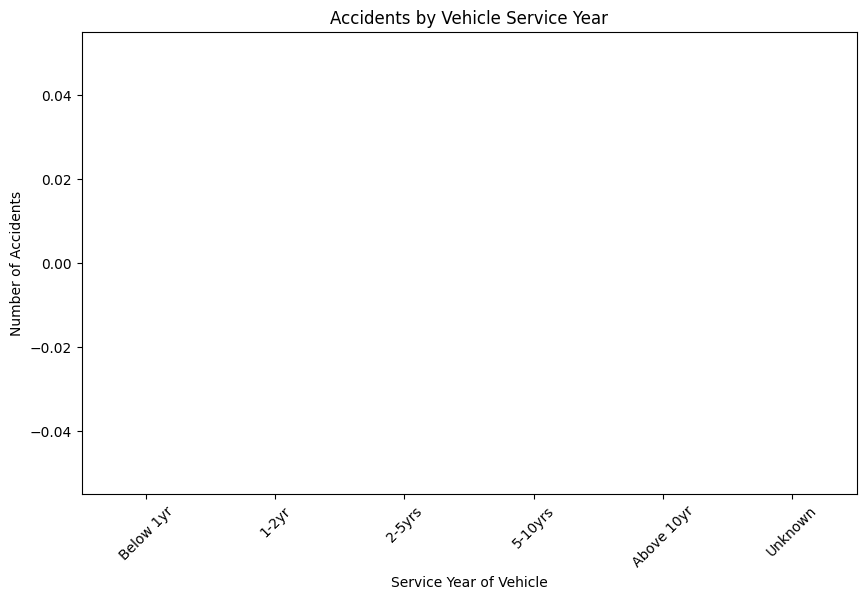

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Service_year_of_vehicle', data=df, palette='autumn', order=['Below 1yr', '1-2yr', '2-5yrs', '5-10yrs', 'Above 10yr', 'Unknown'])
plt.title('Accidents by Vehicle Service Year')
plt.xlabel('Service Year of Vehicle')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

3.Defect vs. Accident Count

<ipython-input-103-56e77cb177fe>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Defect_of_vehicle', data=df, palette='Reds')


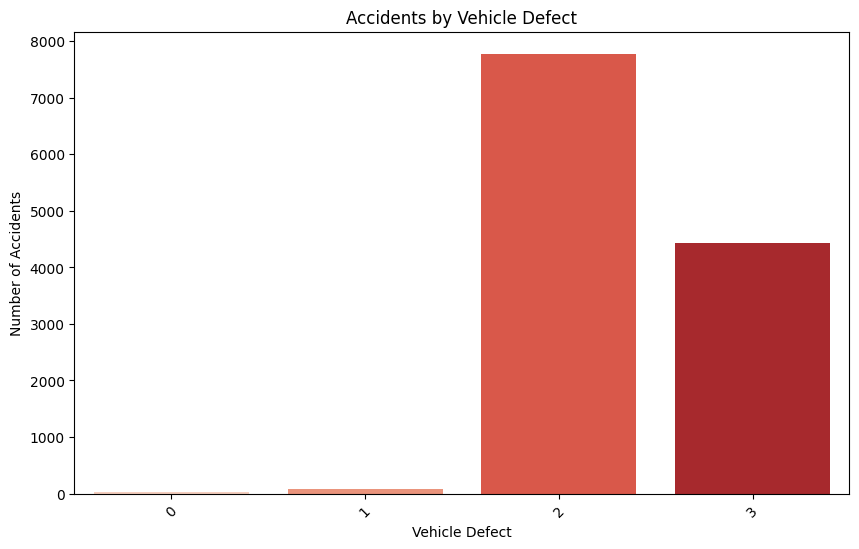

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Defect_of_vehicle', data=df, palette='Reds')
plt.title('Accidents by Vehicle Defect')
plt.xlabel('Vehicle Defect')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

**ACCIDENT CAUSES AND CONTRIBUTING FACTORS**

1.Cause of Accident

<ipython-input-104-4d907f6ca7ee>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Cause_of_accident', data=df, palette='Set3', order=df['Cause_of_accident'].value_counts().index)


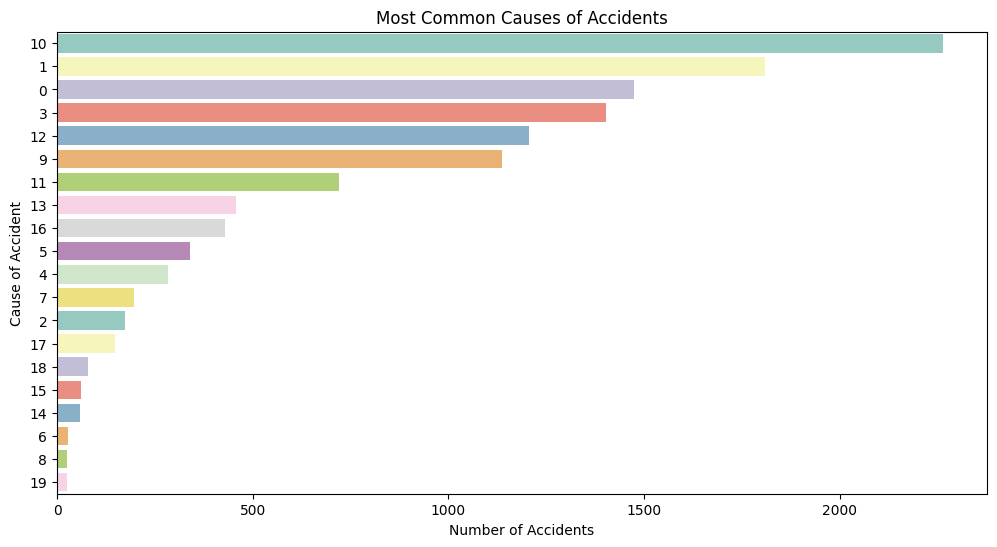

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Cause_of_accident', data=df, palette='Set3', order=df['Cause_of_accident'].value_counts().index)
plt.title('Most Common Causes of Accidents')
plt.xlabel('Number of Accidents')
plt.ylabel('Cause of Accident')
plt.show()

2. ause vs. Severity

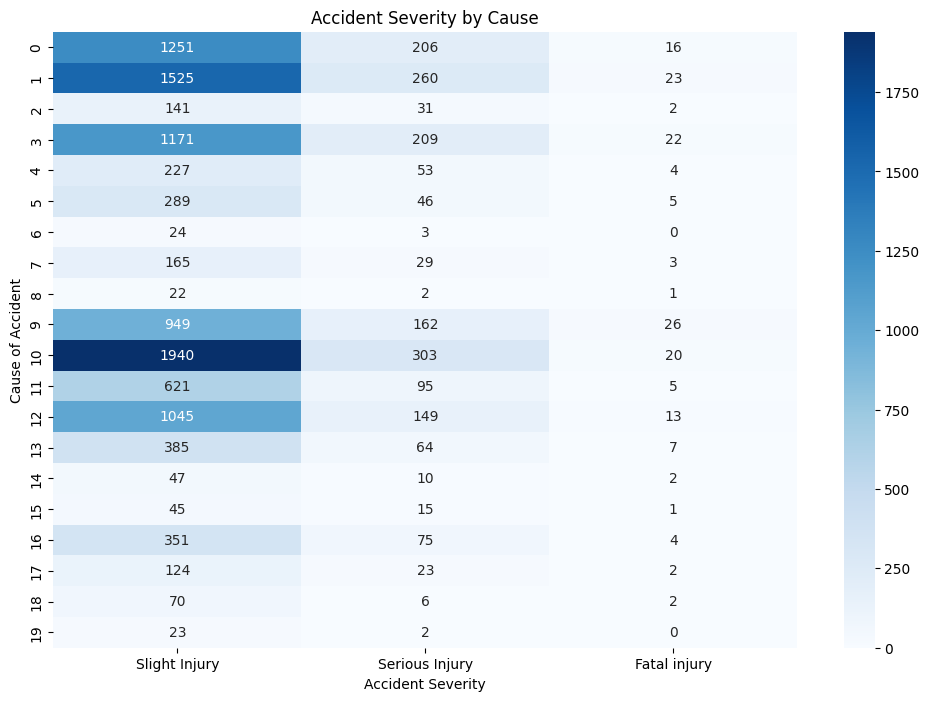

In [ ]:
cause_severity = pd.crosstab(df['Cause_of_accident'], df['Accident_severity'])
plt.figure(figsize=(12, 8))
sns.heatmap(cause_severity, annot=True, cmap='Blues', fmt='d')
plt.title('Accident Severity by Cause')
plt.xlabel('Accident Severity')
plt.ylabel('Cause of Accident')
plt.show()

3.Pedestrian Movement

<ipython-input-106-9051209a9688>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Pedestrian_movement', data=df, palette='YlGnBu')


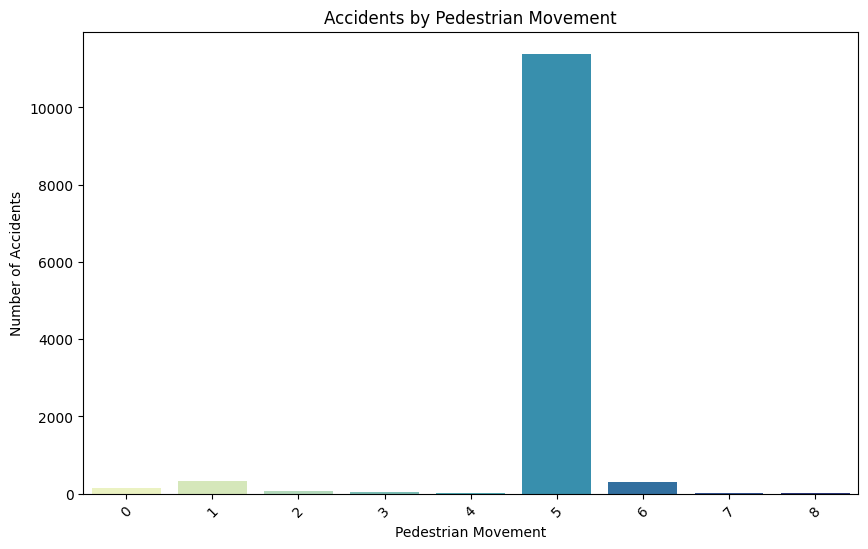

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Pedestrian_movement', data=df, palette='YlGnBu')
plt.title('Accidents by Pedestrian Movement')
plt.xlabel('Pedestrian Movement')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

**TEMPORAL ACCIDENT DISTRIBUTION**

1. Hourly Accident Distribution

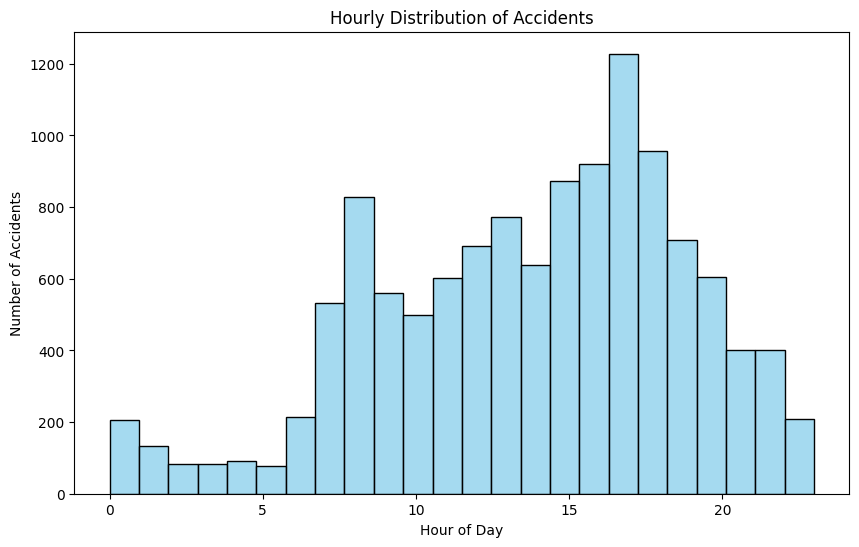

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Hour'], bins=24, color='skyblue')
plt.title('Hourly Distribution of Accidents')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.show()

2. Day of Week Distribution

<ipython-input-108-a477de8425fc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Day_of_week', data=df, palette='viridis', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


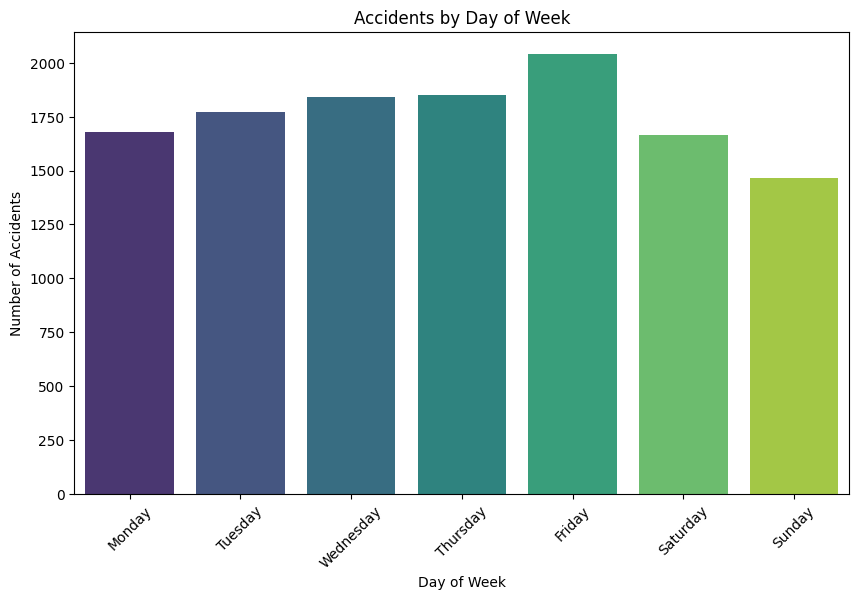

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Day_of_week', data=df, palette='viridis', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Accidents by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

3. Light Conditions

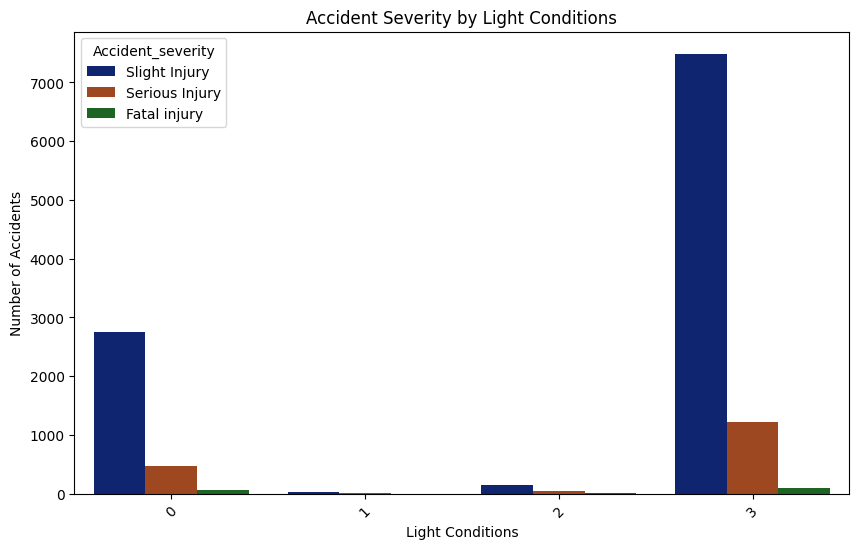

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Light_conditions', hue='Accident_severity', data=df, palette='dark')
plt.title('Accident Severity by Light Conditions')
plt.xlabel('Light Conditions')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()